<div>
<center>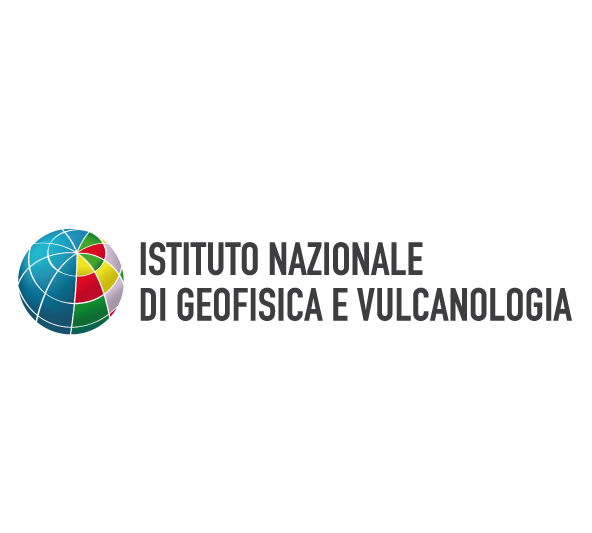</center>
</div>

__Sea Observations Utility for Reprocessing, Calibration and Evaluation  (SOURCE)__




*Authors*: Claudia Fratianni (claudia.fratianni@ingv.it), Simona Simoncelli (simona.simoncelli@ingv.it)
***
# Description
**The objective of this notebook is to** 


SOURCE permits to calibrate and validate ocean models within a selected spatial domain using *in-situ* observations. 
***
This notebook has been developed within the framework of FAIR-EASE project, a RIA project funded under HORIZON-INFRA-2021-EOSC-01-04.

# PLEASE KEEP TIME TO READ THIS PART

Make sure that both python version used to install SOURCE following README doc and used on jupyter is alligned (in this case 3.10). In order to check python version used in jupyter `run the next cell`:

In [1]:
from platform import python_version
print(python_version())

import sys
import os
#print(os.getcwd())
#print()
parent_dir = os.path.dirname(os.getcwd())
#print(parent_dir)
#print()
sys.path.append(parent_dir)
#print(sys.path)
#print()


3.10.12
/home/geofrizz/INGV/source/Source/notebooks

/home/geofrizz/INGV/source/Source

['/home/geofrizz/INGV/source/Source/notebooks', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/geofrizz/INGV/source/.venv/lib/python3.10/site-packages', '/home/geofrizz/INGV/source/Source']



In [2]:
import sys,os,shutil,getpass
import datetime
import numpy as np
import subprocess
import SOURCE
import folium
import random
import matplotlib.pyplot as plt
import altair as alt


from download_CMEMS import *
from urllib.parse import urlparse
from folium import plugins
from netCDF4 import Dataset,num2date


## SOURCE input data set
***

SOURCE implementation uses Near Real Time moored temperature and salinity observation from CMEMS Service. 
First of all you have to create a CMEMS account following the instruction available here: https://data.marine.copernicus.eu/register. 
Each CMEMS ocean product has a dedicated section (__DATA ACCESS__) where you can find all the instruction on how download the data. Please read also the __User Manual__ describing the interested product and how it is organized.

Here they are used observation from __INSITU_GLO_PHYBGCWAV_DISCRETE_MYNRT_013_030__ product covering the Global seas, considering only data in Mediterranean region. 

To facilitate navigation and automatic download, the In Situ TAC provides a set of `index files` that describe the netCDF collections. 

| Index |  Description |
| :- | :- |
| `index_latest.txt`  |  providing access to a sliding window on the latest 31      days (     the current day included) of observations for real-time applications  | 
| `index_monthly.txt`   | accumulating the best copy of a dataset, organised      by platform and by month, for the last 5 years (plus the current year until the last month, not including the current month) |
| `index_history.txt`   |  providing access to the best quality copy of an observation organised by platform  |



#### 1. Enter CMEMS username and password
After the registration, you will be able to dowload the data using CMEMS __username__ and __password__ 

In [5]:
CMEMS_user = 'PUT_USER_ID'
CMEMS_password = 'PUT_PASSWORD'

As stated before, SOURCE focuses on the Near Real Time product/dataset covering the Mediterranean sea coming from Global seas product.Following steps were taken from useful python sample codes developed by CMEMS service and describing in the __Product User Manual for *insitu* product__ .

Please `run the next` to load the info defining such product/dataset:

#### 2. Define CMEMS product and dataset

In [6]:
dataset = {
    'host': 'nrt.cmems-du.eu',#ftp host => nrt.cmems-du.eu for Near Real Time products
    'product': 'INSITU_MED_PHYBGCWAV_DISCRETE_MYNRT_013_035',#name of the In Situ Near Real Time product in the MED area
    'name': 'cmems_obs-ins_med_phybgcwav_mynrt_na_irr',#name of the dataset available in the above In Situ Near Real Time product
    'index_files': ['index_latest.txt'],#file describing the content of the history netCDF file collections available withint he above dataset
    'index_platform': 'index_platform.txt',#files describing the netwotk of platforms contributting with files in the abve collections
}

#### 3. Download the index files

`Run the next cell` to download the index files:

In [7]:
#user=getpass.getuser()
#Local_dir='Users/'+user+'/INPUT_DATA/data/index_files'
print(parent_dir)
Local_dir=parent_dir+'/inputs/data/index_files'

if not os.path.exists(Local_dir):
    os.makedirs(Local_dir)
    
getIndexFiles(CMEMS_user,CMEMS_password,Local_dir,dataset)

/home/geofrizz/INGV/source/Source


PermanentError: 530 Login incorrect.
Debugging info: ftputil 5.0.4, Python 3.10.12 (linux)

#### 4. Define target area 

As the __INSITU_GLO_PHYBGCWAV_DISCRETE_MYNRT_013_030__ product covers all the world ocean, it is possible to set next a bounding box of interest in `the next cell` and run it:

In [ ]:
geospatial_lat_min = 30.0  # enter min latitude of your bounding box
geospatial_lat_max = 46  # enter max latitude of your bounding box
geospatial_lon_min = -6 # enter min longitude of your bounding box
geospatial_lon_max = 37  # enter max longitude of your bounding box
targeted_bbox = [geospatial_lon_min, geospatial_lat_min, geospatial_lon_max, geospatial_lat_max]  # (minx, miny, maxx, maxy)

Let's see it on a map, `run the next cell`

In [ ]:
m = folium.Map(location=[53.0, 0], zoom_start=4)
upper_left = [geospatial_lat_max, geospatial_lon_min]
upper_right = [geospatial_lat_max, geospatial_lon_max]
lower_right = [geospatial_lat_min, geospatial_lon_max]
lower_left = [geospatial_lat_min, geospatial_lon_min]
edges_ = [upper_left, upper_right, lower_right, lower_left]
polygon = folium.vector_layers.Polygon(locations=edges_)
m.add_child(polygon)
m.fit_bounds(polygon.get_bounds())
m

In [ ]:
info = getIndexFilesInfo(CMEMS_user, CMEMS_password, dataset, Local_dir, targeted_bbox)

#### 5. Obtain the interested data info subsetting by bounding-box

`Run the next cell` to obtain the subset of files with data in such area:

In [ ]:
#info['spatialOverlap'] = info.apply(spatialOverlap,targeted_bbox=targeted_bbox,axis=1)
#condition1 = info['spatialOverlap'] == True
#subset = info[condition1]
#subset.transpose()

#### 6. Obtain the interested data info subsetting by time-range

In [ ]:
targeted_range = '2023-06-26T00:00:00Z/2023-07-11T00:00:00Z' #set your own!
info['timeOverlap'] = info.apply(timeOverlap,targeted_range=targeted_range,axis=1)
condition1 = info['timeOverlap'] == True
subset = info[condition1]
subset.transpose()

#### 7. Obtain the interested data info subsetting by data-type

In [ ]:
targeted_data_type = 'MO'
condition2 = info['data_type'] == targeted_data_type
subset = info[condition2]
subset.transpose()

#### 8. Subsetting by several criterias at once

In [ ]:
subset = info[condition1 & condition2]
subset.transpose()

#### 9. Downloading

After you have created your own subset (see above examples about how-to), we will loop over the files in such subset and download each of them from the FTP server thanks to the file_name column, field that contains the ftp link to the file.
`Run the next cells`:



In [ ]:
output_directory = '/Users/'+user+'/INPUT_DATA/OBSERVATION/MO/'#It changes according to selected data-type
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [ ]:
treshold = 200 #Please set a file number maxima to download. 
#This is just an example and we do not wanna trigger the download of too many files!

In [ ]:
with ftputil.FTPHost(dataset['host'], CMEMS_user, CMEMS_password) as ftp_host:  # connect to CMEMS FTP
    for i in range(0, len(subset)):
        if i<treshold:
            filepath = subset.iloc[i]['file_name'].split(dataset['host'])[1]
            ncdf_file_name = filepath.split('/')[-1]
            if ftp_host.path.isfile(filepath):
                print('.....Downloading ' + ncdf_file_name)
                cwd = os.getcwd()
                os.chdir(output_directory)
                try:
                    ftp_host.download(filepath, ncdf_file_name)  # remote, local
                    print('Done!')
                except Exception as e:
                    print('error!: FTP download failed ...')
                os.chdir(cwd)   
print('FTP Download finished')

In [ ]:
numberOfFiles = 200 #we will check just a sample of files not all

In [ ]:
m = folium.Map(location=[39.3, 0], zoom_start=5)
m.add_child(folium.vector_layers.Polygon(locations=edges_))
for platform, files in subset[:numberOfFiles].groupby(['platform_code', 'data_type']):
    color = "%06x" % random.randint(0, 0xFFFFFF)
    #Last reported position to map as marker
    i = len(files)-1
    m.add_child(folium.Marker([files.iloc[i]['last_latitude_observation'], files.iloc[i]['last_longitude_observation']], popup=files.iloc[i]['platform_code']+' last position' ))
#Zooming closer
m.fit_bounds(edges_, max_zoom=8)
m

## Observations module
***

This module is designed to prepare observation-based data through a pre-processing and re-processing operations. Data come from Near Real Time moored temperature and salinity observations distributed by Copernicus Marine Environment and Monitoring Service (__CMEMS__). Data are first pre-processed to match SOURCE format prerequisites by selecting the __space-time limits__, the __instruments__, the __variables__ and the __desired QFs__ to apply. The data are then re-processed by aggregating depth levels, removing duplicates and reordering record coordinate (time). Successively the data are quality controlled (QCed) maintaining the original sempling. The reprocessed and QCed data are saved and averaged by time. 

In the cell below you should provide following information:

1. the observation-based data path;
2. the __Essential Ocean Variables__ (EOVs) to be extract as NetCDF CF conventions __standard_name__ attributes;
3. Base working directory;
4. Output directory;
5. the parameter which selects the __QFs__ to apply (1 for *good data*, 1 and 2 for both *good* and *probably good* data);
6. Update mode execution switch (OPTIONAL);
7. Start date (OPTIONAL);
8. End date (OPTIONAL);
9. Latitude and Longitude limits;
10. Input CMEMS "instrument type" metadata filter space separated string (OPTIONAL);
11. Platform names CSV table;
12. verbosity switch (OPTIONAL)

#### 1. Define in the `next cell` the input information:

In [ ]:
user=getpass.getuser()
# Observation base-data path
InDir='/Users/'+user+'/INPUT_DATA/OBSERVATION/MO'

# Essential Ocean Variables to be extract
InFields='sea_water_temperature'

# Working directory
WorkDir='/Users/'+user+'/TEST_SOURCE/OBSERVATION/work'

# Pre-processed directory
PreDir='/Users/'+user+'/TEST_SOURCE/OBSERVATION/pre-processed'

# Output directory
OutDir='/Users/'+user+'/TEST_SOURCE/OBSERVATION/statistic/'#output'

#Climatology directory
CliDir='/Users/'+user+'/TEST_SOURCE/OBSERVATION/history/statistic_qc_3/output/climatology'

# Merged directory
MerDir='/Users/'+user+'/TEST_SOURCE/OBSERVATION/merged'

# History directory: in CREATION mode you have to create the reference history:
HisDir='/Users/'+user+'/TEST_SOURCE/OBSERVATION/history/'

# History directory: in UPDATE mode you have to concatenate with previous period:
#HisDir='/Users/'+user+'/TEST_SOURCE/OBSERVATION/????/'

# Original DAC valid quality flags to use (space separated string, example: "0 1 2")
sel_QF='0 1 2'

# Processing mode
pr_mode='False' #(False=CREATION MODE; TRUE=UPDATE MODE)

# Start and end date

str_date='20230626'
end_date='20230711'

#Region longitude - latitude limits
Reg='-18.125 36.5 30 46'

#Iteration number
it_nu=3

# Temporal resolution
Temp_res='dm'

# Masking foreign seas switch for Mediterranean Sea processing 
msk_med='True'

#### 2. `Run the next cell` to pre-processing the observation based-data in the SOURCE internal netCDF format:

In [ ]:
SOURCE.obs_postpro.insitu_tac_pre_processing.insitu_tac_pre_processing(InDir,InFields,WorkDir,PreDir,sel_QF,pr_mode,str_date,end_date,Reg,True)

#### 3. `Run the next cell` to re-processing observational based-data to aggregate depth levels,remove duplicates and re-order record coordinate (time): 

In [ ]:
SOURCE.obs_postpro.obs_postpro.obs_postpro(PreDir,PreDir,InFields,WorkDir,OutDir,it_nu,'',str_date,end_date,Reg,msk_med)

#### 4. Create history database
If you are in __CREATION__ mode, `run the next cell` to create history database directory

In [ ]:
shutil.copytree(OutDir,HisDir)

#### 5. Merge the Metadata Database
In __UPDATE__ mode the produced data set has to be concatenated with a historical dataset generated in __CREATION__ mode. 

In [ ]:
SOURCE.obs_postpro.metadata_merger.metadata_merger(HisDir,OutDir,MerDir)

#### 6. Merge the Database

In [ ]:
SOURCE.real_time_concatenator.real_time_concatenator(HisDir+Temp_res,OutDir+Temp_res,WorkDir,MerDir+Temp_res,InFields)

<font color='red'>Switch from CREATION to UPDATE mode</font>

First time the module must be run in __CREATION__ mode in order to create reference time series. To start __UPDATE__ mode, please remember to swith pr_mode to `True` and HisDir to the directory containing the dataset to be merged. 

## Models module
***

This module aims to extract and aggregate model time series at the observed space-time moorings (defined by
the observational module) locations in order to compare model output with observations. 
The comparison is first qualitative, through visual inspection (allowing continuous monitoring of both the instrument calibration and the sea conditions at the mooring location) and then quantitative, through the skill scores computation performed in the __Cal/Val__ sub-module. 

Two INGV model data sets have been used for the SOURCE setup but other CMEMS products, covering the Mediterranean Sea domain, could be integrated. 

In order to speedup the concatenation, one suggestion would be to split model datasets in the input directory into subfolders: in this case, each folder __MUST__ be named with the standard_name attribute of the field that the datasets contains inside. Example:
* input directory --> **sea_water_temperature** directory --> **all datasets with sea_water_temperature here**
etc.



#### 1. Download the Mediterranean reanalysis (MEDREA)
The Mediterranean Sea reanalysis (MEDREA) was developed at INGV within the framework of MyOcean Project and successively distributed by CMEMS until Dicember 2020. Now it is available though __INGV ERDDAP service__ and can be downloaded through following command:

In [ ]:
import urllib.request

In [ ]:
# Define the base url
base_url='http://oceano.bo.ingv.it/erddap/griddap'

# Define the dataset ID 
dataID='MedRea16_3D'

# Specify the type of grid data file that you want to download
ftype='.nc'

########################
# Define the time range
########################

YY_start=2016
MM_start=7
DD_start=10

YY_end=2016
MM_end=7
DD_end=11

start_date = datetime.date(YY_start,MM_start,DD_start)
end_date = datetime.date(YY_end,MM_end,DD_end)
    
start_date.strftime("%Y-%m-%dT%H:%M:%SZ")
end_date.strftime("%Y-%m-%dT%H:%M:%SZ")

########################
# Define the depths of 
# interest
########################
dpt_start=1.472
dpt_stop=4.587


# Definine the domain of interest
lat_min = 30.1875
lat_max = 45.9375
lon_min = -6.
lon_max = 36.25
id_sub = 1

# Define the variable(s) of interest
variable_name = ['votemper','vosaline']

# Model data path
InDir='/Users/'+user+'/INPUT_DATA/MODEL/'

base = (
    '{}' # base url
    '/{}' # dataset ID
    '{}?' # Filetype
    ).format

var_set = (
    '{}'# variable
    '%5B({}):'# time
    '{}:'
    '({})%5D'
    '%5B({}):'# depth
    '{}:'
    '({})%5D'
    '%5B({}):'# lat
    '{}:'
    '({})%5D'
    '%5B({}):'# lon
    '{}:'
    '({})%5D'# start
    ).format

url = base(
    base_url,
    dataID,
    ftype,
 )


for vv in np.arange(0,(np.size(variable_name))):
 var_int = var_set(
     variable_name[vv],
     start_date,
     id_sub,
     end_date,
     dpt_start,
     id_sub,
     dpt_stop,
     lat_min,
     id_sub,
     lat_max,
     lon_min,
     id_sub,
     lon_max,
 )
 if vv ==0:
  url += var_int
 else:
  url += ','+var_int  

file_output=InDir+dataID+'_'+start_date.strftime("%Y%m%d")+'_'+end_date.strftime("%Y%m%d")+'.nc'
print(file_output)
urllib.request.urlretrieve (url, file_output)

#### 3. Split in daily files (if needed, uncomment following lines)

In [ ]:
#delta = datetime.timedelta(days=1)
#while start_date <= end_date:
# start_date +=delta

#### 4. Define in the `next cell` the input information:

In [ ]:
user=getpass.getuser()
# Model data path
InDir='/Users/'+user+'/INPUT_DATA/MODEL'

# Essential Ocean Variables to be extract
InFields='sea_water_potential_temperature'

# Temporal resolution
Temp_res='dm' #daily mean

# Working directory
WorkDir='/Users/'+user+'/TEST_SOURCE/MODEL/work/input_'+Temp_res
if not os.path.exists(WorkDir):
    os.makedirs(WorkDir)
    
# Temporary working directory
TmpDir='/Users/'+user+'/TEST_SOURCE/MODEL/work/work_'+Temp_res

# Post-processed directory
PostDir='/Users/'+user+'/TEST_SOURCE/MODEL/post-processed'
if not os.path.exists(PostDir):
    os.makedirs(PostDir)

# Merged directory
MerDir='/Users/'+user+'/TEST_SOURCE/MODEL/merged/'+Temp_res
if not os.path.exists(MerDir):
    os.makedirs(MerDir)

# History input observation
InSituHisDir='/Users/'+user+'/TEST_SOURCE/OBSERVATION/history/'#static/'

# History model directory 
HisDir='/Users/'+user+'/TEST_SOURCE/MODEL/history/'
#if not os.path.exists(HisDir):
#    os.makedirs(HisDir)

# If not present embedded in the model dataset, the user must provide the land-sea mask separately in NetCDF format
LS_mask='/Users/'+user+'/INPUT_DATA/STATIC/meshmask_SYS4C-sys4a5.nc'

#Maximum acceptable horizontal distance in km
Dist_max=12

#### 3. `Run the next cell` to link model data to be processed:

In [ ]:
sorted_lista = sorted([ x for x in os.listdir(InDir) if x.endswith('T.nc')])
for ff in sorted_lista:
    os.symlink(InDir+'/'+ff,WorkDir+'/'+ff)

#### 4. `Run the next cell` to extract model time series at the observed space-time mooring locations:

In [ ]:
SOURCE.model_postpro.model_postpro.model_postpro(InSituHisDir,WorkDir,InFields,TmpDir,PostDir,Dist_max,LS_mask)

#### 5. `Run the next cell` to merge database:

In __UPDATE__ mode the produced data set has to be concatenated with a historical dataset generated in __CREATION__ mode.

In [ ]:
shutil.copytree(MerDir,HisDir)

In [ ]:
SOURCE.real_time_concatenator.real_time_concatenator(HisDir,PostDir+'/'+Temp_res,TmpDir,MerDir,InFields)

<font color='red'>Switch from CREATION to UPDATE mode</font>

First time the module must be run in __CREATION__ mode in order to create reference time series (.../history/merged/dm). To start __UPDATE__ mode, please remember to swith HisDir to the directory containing the dataset to be merged. 

#### Cal/Val module
***
SOURCE evaluates model performance through the computation of basic __skill's scores__ at the platform locations once the observed and synthetic data are generated. The cal/val module loads both observed and synthetic data time series and computes the class 4 metrics (`Simoncelli et al., 2016`). 

#### 1. OBSERVATION dataframe creation 
***

In order to visualize observation and model, first it has to be created observation dataframe containing interesting information

In [ ]:
import json
import math

InsMerDir='/Users/'+user+'/TEST_SOURCE/OBSERVATION/mergeddm/sea_water_temperature'
ModMerDir='/Users/'+user+'/TEST_SOURCE/MODEL/merged/dm/sea_water_potential_temperature'

######################################
####### INSITU OBSERVATION ###########
######################################

pcode=[]
pname=[]
wcode=[]
t=[]
lon=[]
lat=[]
obse=[]
k_obs=[]

sorted_files_obs=sorted([ x for x in os.listdir(InsMerDir) if x.endswith('nc')])

for f in sorted_files_obs[0:2]:
    f_nc=Dataset(InsMerDir+'/'+f,'r')
    t.append(f_nc.variables['time'][:])
    lon.append(f_nc.variables['lon'][:])
    lat.append(f_nc.variables['lat'][:])
    obse.append(np.array(f_nc.variables['sea_water_temperature'][:,-1]))
    k_obs.append('insitu')
    pcode.append(f_nc.getncattr('platform_code'))
    pname.append(f_nc.getncattr('platform_name'))
    wcode.append(f_nc.getncattr('wmo_platform_code'))
    
data_obs = pd.DataFrame({'platform_code': pcode,
        'platform_name': pname,
        'wmo_platform_code': wcode,
        'time': t,
        'lon': lon,
        'lat': lat,
        'obs': obse,
        'kind': k_obs
        })


######################################
#######        MODEL       ###########
######################################

sorted_files_mod=sorted([ x for x in os.listdir(ModMerDir) if x.endswith('nc')])

mod_T=[]
mod_time=[]
k_mod=[]
for f in sorted_files_mod[0:2]:
    f_nc=Dataset(ModMerDir+'/'+f,'r')
    mod_time.append(f_nc.variables['time'][:])
    mod_T.append(np.array(f_nc.variables['sea_water_potential_temperature'][:,-1]))
    k_mod.append('model')
    
data_mod=pd.DataFrame({'time': mod_time,'model': mod_T,'kind': k_mod})


In [ ]:
m = folium.Map(location=[43.5, 15], zoom_start=4)

for p in np.arange(0,len(lon)):
    icon_url = '/Users/'+user+'/JUPYTER_NOTEBOOK/ICON/buoy_icon_2.png'
    icon = folium.features.CustomIcon(icon_url,icon_size=(28, 30)) 
    
    axis_dates=[]
    bias_d=[]
    rms_d=[]
    for i in np.arange(0,np.size(t[p])):
        axis_dates.append(num2date(t[p][i],units = "seconds since 1970-01-01T00:00:00Z").strftime('%Y%m%d'))
        bias_d.append(obse[p][i]-mod_T[p][i])
        rms_d.append( (obse[p][i]-mod_T[p][i])**2)
        
    bias=np.mean(bias_d)
    rms=(math.sqrt(np.sum(rms_d)/i))
    
    data_obs_1=pd.DataFrame({'time':axis_dates,'obs':obse[p],'kind': k_obs[p]})
    data_mod_1=pd.DataFrame({'time':axis_dates,'model':mod_T[p],'kind': k_mod[p]})
    
    
    chart_title=alt.TitleParams(text=str(data_obs['platform_name'][p])+', Temperature [degrees_C]',fontSize=22,subtitle = ['rms='+str(np.around(rms,2)),'bias='+str(np.around(bias,3))],subtitleColor='red',anchor='start')
    
    chart_obs=alt.Chart(data_obs_1).mark_line(color='black',strokeWidth=2.5).encode(x=alt.X('time',axis=alt.Axis(title='Time',labelAngle=-45)),y=alt.Y('obs',scale=alt.Scale(zero=False),axis=alt.Y(title='Temperature')),color=alt.Color("kind"))#.interactive()
    chart_mod=alt.Chart(data_mod_1).mark_line(color='red',strokeWidth=2.5).encode(x=alt.X('time',axis=alt.Axis(title='Time',labelAngle=-45)),y=alt.Y('model',scale=alt.Scale(zero=False),axis=alt.Y(title='Temperature')),color=alt.Color("kind")).properties(width=350,height=150,title=chart_title)
    chart=chart_obs+chart_mod
    chart2=json.loads(chart.to_json())
    
    popup=folium.Popup(chart2)
    folium.features.VegaLite(chart2,width=450, height=150).add_to(popup)
    folium.Marker([data_obs['lat'][p],data_obs['lon'][p]],icon=icon,tooltip=str(data_obs['platform_name'][p]),popup=popup).add_to(m)
tile = folium.TileLayer(
   tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
   attr='Esri',
   name='Esri Satellite',
   overlay=False,
   control=True
  ).add_to(m)
m